## MNIST and custom architectures
This tutorial shows how you can easily swap building blocks in the `proteovae.models` module with native PyTorch. 


In [ ]:
!pip install proteovae

In [1]:
from proteovae.models import BetaVAE, BaseConfig
import proteovae.models.base as base

from torchvision import datasets
from torchvision.transforms import ToTensor, Compose, Lambda 
from torch.utils.data import DataLoader 
import torch 
from torch import nn 


To load the mnist data we follow the basic outline from [this torch tutorial](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html), but in our case we compose the transforms to flatten the 28x28 images into 784 dimensions

In [2]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=Compose([ToTensor(), Lambda(lambda x: torch.flatten(x))]),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=Compose([ToTensor(), Lambda(lambda x: torch.flatten(x))]),
)

Define the data loaders

In [3]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

print(next(iter(train_dataloader))[0].shape)

torch.Size([64, 784])


## Model init

In [5]:
config = BaseConfig(
    input_dim = 784, 
    latent_dim= 2,
    device = "cuda" if torch.cuda.is_available() else "cpu"
)

#using the de-facto models.base Encoder (fully connected)
enc = base.Encoder(input_dim = config.input_dim, 
                   latent_dim = config.latent_dim, 
                   hidden_dims = [256,64,]
                   )

#custom convolutional decoder 
class CustomDecoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        
        self.conv_block = nn.Sequential(
            nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, 4, stride=2, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 1, 3, stride=1, padding=0),
            nn.Sigmoid(),
        )
        
        #wanted to see if it worked adding this 
        self.linear_block = nn.Sequential(
            nn.Linear(self.latent_dim, 4*4*64),
            nn.ReLU(),
        )
        
    def forward(self, x):
        features = self.linear_block(x)
        features = torch.unflatten(features, dim = 1, sizes = (64,4,4))
        img = self.conv_block(features)
        img = torch.flatten(start_dim = 1, end_dim = -1)
        return img
    

dec = CustomDecoder(config.latent_dim)

In [6]:
model = BetaVAE(config=config, encoder = enc, decoder = dec)
model.eta = 0
model.gamma = 0

## Training 🏋️

In [7]:
from proteovae.trainers import ScheduledTrainer

optimizer = torch.optim.Adam(model.parameters(), lr=5e-04)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda e: max(0.96**(e), 5e-04), last_epoch=- 1)

trainer = ScheduledTrainer(model, optimizer, scheduler)

In [8]:
trainer.train(train_dataloader, epochs=30)

Epoch [1/30]
(beta: 1.0, eta: 0.0, gamma: 0.0)
lr=5.00e-04


KeyboardInterrupt: 

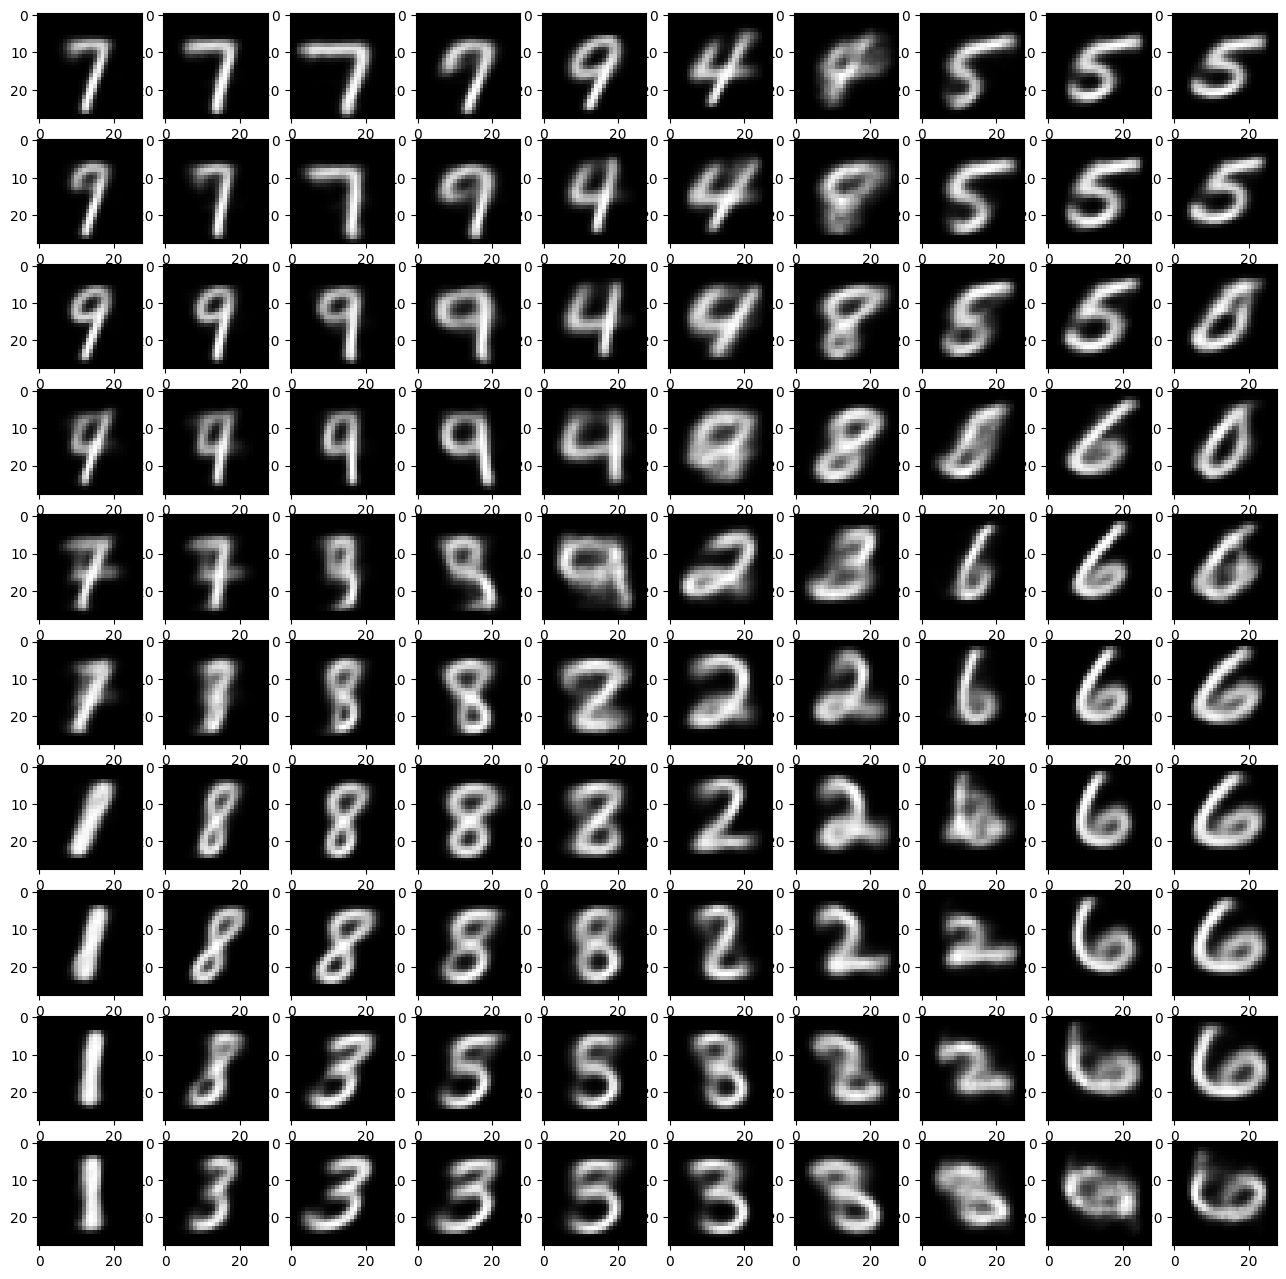

In [20]:
import matplotlib.pyplot as plt 

#just do the grid thing 
x_grid = torch.linspace(-1, 1, 10)
y_grid = torch.linspace(-1, 1, 10)

fig, axs = plt.subplots(10,10, figsize=(16,16))

model.eval()

with torch.no_grad():
    for i, x in enumerate(x_grid):
        for j, y in enumerate(y_grid):
            z = torch.tensor([x,y], device = device).unsqueeze(0)

            img = model.decoder(z).view(28,28) #should be fine 

            axs[i,j].imshow(img.cpu().squeeze().numpy(), cmap="gray")